In [10]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

In [30]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='spine_train.jsonl', split='train')
val_dataset = load_dataset('json', data_files='spine_validation.jsonl', split='train')

In [21]:
def formatting_func(example):
    text = f"### Question about Spine Health: {example['question']}\n ### Expert Answer: {example['answer']}"
    return text

In [18]:


#-------------------------- LOAD MISTRAL -------------------------------------------------



In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"

# Configure the model to use 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the quantized pre-trained Mistral-7B
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:


#-------------------------- TOKENIZATION -------------------------------------------------



In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True
)

#Mistral Dependency
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [31]:
#This function tokenizes the user input
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt)

In [29]:


#-------------------------- DATA VISUALIZATION -------------------------------------------------



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


156


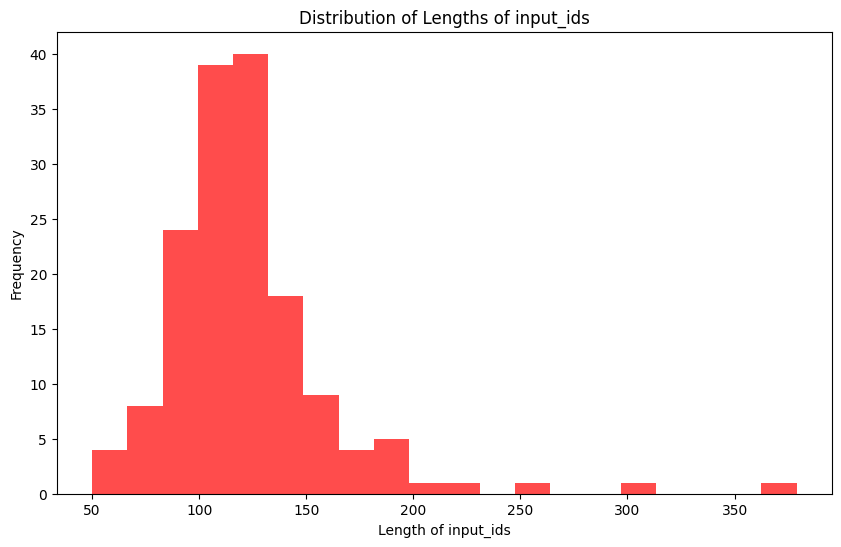

In [32]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='red')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [37]:
max_length = 256

#This function pads all responses to same length
def generate_final_tokens(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [38]:
tokenized_train_dataset = train_dataset.map(generate_final_tokens)
tokenized_val_dataset = val_dataset.map(generate_final_tokens)

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

In [39]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 774, 22478, 684, 1670, 473, 6377, 28747, 1824, 460, 272, 1868, 8670, 1339, 304, 13945, 297, 22656, 668, 1475, 16732, 15871, 28804, 13, 774, 1529, 2482, 26307, 28747, 415, 1834, 302, 668, 1475, 16732, 11254, 5827, 659, 2598, 5864, 8670, 1339, 28725, 6311, 297, 272, 5020, 302, 7454, 25334, 294, 791, 27319, 304, 312, 23005, 5174, 28723, 2387, 3014, 4431, 14657, 716, 4097, 312, 23005, 5174, 7034, 28725, 1259, 390, 7312, 6883, 3522, 3316, 264, 1370, 28725, 3522, 2202, 264, 1819, 354, 3522, 3370, 28725, 690, 659, 4894, 22449, 2903, 297, 1846, 4590, 5572, 737, 7312, 28725, 6447, 301, 28725, 304, 843, 316, 826, 2602, 28723, 16569, 28725, 736, 28742, 28713, 15260, 3332, 297, 272, 1203, 18071, 352, 302, 8894, 28725, 1259, 390, 332, 1757, 309, 745, 16732, 4242, 1326, 266, 1485, 5595, 8894, 28725, 690, 739, 9837, 395, 312, 23005, 5174, 28725, 541, 1736, 298, 5864, 14573, 12106, 28723, 6880, 6563, 1250, 26761, 349, 272, 4628, 302, 17854, 8894, 28725, 2490, 613, 28753, 3315, 28713, 325, 507, 223

156


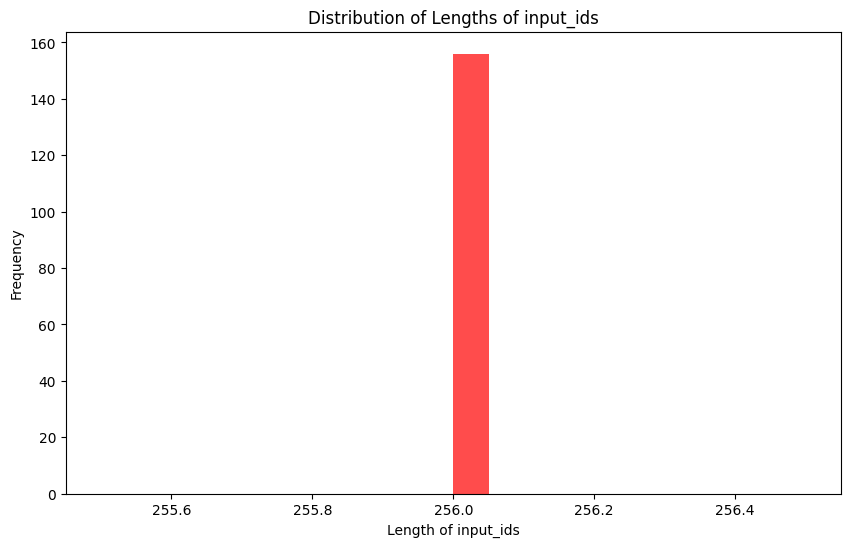

In [40]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:


#-------------------------- BASE MISTRAL -------------------------------------------------



In [48]:
#Adding an eval prompt

eval_prompt = "Spine rehab advice:#"

In [50]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True
)

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()

with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Spine rehab advice:#1. Don’t be a hero

I know you want to get back to work, but if your doctor says you need time off, take it!  If you don’t, you may end up with more problems than you started with.

#2. Get moving

The best way to recover from an injury is to keep moving.  This doesn’t mean that you should go out and run a marathon or lift weights like Arnold Schwarzenegger, but you do need to move around as much as possible.  Walking is one of the best exercises for people who have back pain.  It helps strengthen your muscles and improve flexibility.  You can also try swimming or biking.  Just make sure not to overdo it!

#3. Eat right

Eating healthy foods will help reduce inflammation in your body which could lead to further damage.  Try eating lean meats such as chicken breast instead of red meat because they contain less fat.  Also avoid processed foods like chips and cookies since these are high in sugar and salt content.

#4. Take care of yourself mentally

Back pain can caus

In [ ]:


#-------------------------- LORA MISTRAL -------------------------------------------------



In [53]:
# Parameter Efficient Fine-tuning
from peft import prepare_model_for_kbit_training

"""
Enable gradient checkpointing for the model. This is a technique to save memory during training
# by trading compute for memory. It stores intermediate activations during the forward pass
# and recomputes them during the backward pass, allowing large models to be fine-tuned on hardware
# with limited memory.
"""
model.gradient_checkpointing_enable()

"""
Prepare the model for k-bit training, which is a form of quantization.
# It modifies the model to train only a small fraction of the parameters (k-bits)
# rather than the full precision parameters. This allows for faster and more memory-efficient fine-tuning.
# The function modifies the model in-place and returns it.
"""
model = prepare_model_for_kbit_training(model)

In [56]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [ ]:


#-------------------------- LORA CONFIG -------------------------------------------------



In [58]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,                 #Rank Matrix Length
    lora_alpha=64,        #Scaling Factor
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head"
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [59]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [60]:
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [61]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In [63]:
#CUDA
print(torch.cuda.device_count())

1


In [ ]:


#-------------------------- TRAINING -------------------------------------------------



In [67]:
import transformers
from datetime import datetime

project="verte"
base_model_name="mistral"
run_name=base_model_name + "-" + project
output_dir="./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,                          #Number of warmup steps for learning rate scheduler.
        per_device_train_batch_size=2,           #Batch Size
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=300,
        learning_rate=2.5e-5,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"  # Unique run name.
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),   
)

model.config.use_cache = False   # Disable caching to avoid warnings during training.
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
25,0.116100,2.169014
50,0.132200,2.126606
75,0.106600,2.293066
100,0.112100,2.197062
125,0.096100,2.221704
150,0.083200,2.387602
175,0.076800,2.415130
200,0.077900,2.296530
225,0.054000,2.435997
250,0.055300,2.478757


/home/user/mambaforge/envs/Verte/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/user/mambaforge/envs/Verte/lib/python3.8/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/user/mambaforge/envs/Verte/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of u

TrainOutput(global_step=300, training_loss=0.08508797685305278, metrics={'train_runtime': 285.1777, 'train_samples_per_second': 2.104, 'train_steps_per_second': 1.052, 'total_flos': 6587347881689088.0, 'train_loss': 0.08508797685305278, 'epoch': 4.55})

In [69]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [71]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-verte/checkpoint-300")

In [75]:
eval_prompt = "I am facing lumbar stenosis, suggest treatment # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


I am facing lumbar stenosis, suggest treatment # 2
 ### Expert Answer: Treatment #2 for lumbar stenosis involves a combination of core and spine stability exercises. This approach aims to stabilize the spine and support it rather than forcing flexion, which can exacerbate stenosis symptoms. The exercise program includes exercises like the bear position, disc loading exercises, and nerve gliding exercises to promote healing and reduce inflammation around the nerves. It's important to note that while this treatment is effective for many people with lumbar stenosis, it may not work for everyone. If symptoms persist after several months of consistent practice, it's advisable to consult a healthcare professional for further evaluation.
